In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utils.make_pairs import make_pairs

## Prepare Data For Siamese Network

Load Data and Labels

In [53]:
train_data_dir = r'C:\Users\jands\Market-1501-v15.09.15\bounding_box_train'
val_data_dir = r'C:\Users\jands\Market-1501-v15.09.15\bounding_box_val'

file_paths_train = tf.data.Dataset.list_files(train_data_dir + '/*.jpg')
file_paths_val = tf.data.Dataset.list_files(val_data_dir + '/*.jpg')

# Define the function to extract the label from the file name
# works for my specific directory path...
def extract_label(file_path):
    label = tf.strings.split(file_path, '_')
    label = tf.strings.split(label, '\\')
    return int(label[2][1])

def read_and_decode(file_path):
    label = extract_label(file_path)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

print("[INFO] loading data...")

dataset_train = [read_and_decode(file) for file in file_paths_train]
dataset_val = [read_and_decode(file) for file in file_paths_val]

[INFO] loading data...


Visualize Training Data

IMAGE SHAPE:  (128, 64, 3)


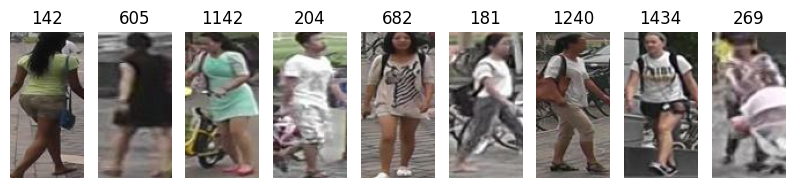

In [54]:
plt.figure(figsize=(10, 10))
subplot_pos = 1

for image, label in dataset_train[:9]:
  ax = plt.subplot(1, 9, subplot_pos)
  subplot_pos += 1
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")

print("IMAGE SHAPE: ", image.shape)

In [55]:
labels = [label for image, label in dataset_train]
unique_labels = np.unique(np.array(labels))

idxs = [np.where(labels == unique_label)[0] for unique_label in unique_labels]

for unique_label in unique_labels:
    idxs = np.where(labels == unique_label)[0]
    print(f"{unique_label} => {len(idxs)} : {idxs}")

2 => 46 : [  234   383   651   779  1232  1263  1393  1505  1506  1523  1610  1784
  1920  2242  2290  2603  2776  2834  2882  2919  3925  4437  4457  4497
  4685  4817  5264  5500  5548  6379  6913  7075  7076  8110  8443  8857
  8881  9246  9928 10016 10100 10807 10929 11108 11210 12827]
7 => 7 : [ 195  572  641 1664 3664 7216 7857]
10 => 11 : [ 1075  1258  2270  3345  3433  7294  7369  7822  8059  9873 11658]
11 => 15 : [  631  1231  1862  2015  2924  3300  7146  7260  7610  8919  9726 10554
 11358 12541 12843]
12 => 6 : [ 1885  4231  8749  9295  9625 11717]
20 => 6 : [ 1844  2355  5337  6294  8537 11706]
22 => 59 : [   13   494   563   710   746   763  1225  1325  2376  2649  2780  2975
  3009  3941  4655  4668  4722  5029  5234  5293  5973  6041  6159  6238
  6325  6603  6618  6632  6677  6709  7028  7393  7809  7836  8351  8605
  8998  9059  9209  9266  9631  9651  9985  9992 10219 10227 10280 10362
 10566 10672 11028 11238 11286 11561 11747 11978 12032 12173 12251]
23 => 20 : [ 

Make Pairs

In [56]:
train_pair_x, train_pair_y = make_pairs(dataset_train)
val_pair_x, val_pair_y = make_pairs(dataset_val)

c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


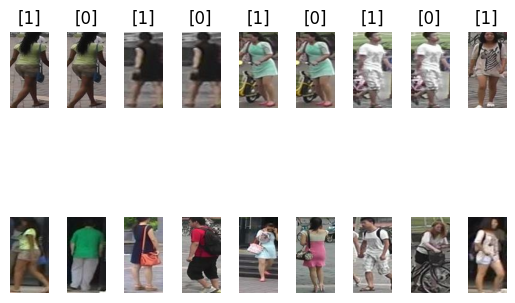

In [57]:
fig, axes = plt.subplots(2, 9)
plt.subplots_adjust(wspace=0.5, hspace=0)
j = 0

for img_1, img_2 in train_pair_x[:9]:
  axes[0, j].imshow(img_1)
  axes[1, j].imshow(img_2)
  axes[0, j].set_title(train_pair_y[j])
  axes[0, j].set_axis_off()
  axes[1, j].set_axis_off()
  j += 1

## Creating Siamese Network

In [58]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from utils.euclidean_distance import euclidean_distance

Choose a pretrained model

In [59]:
# the image size for all the images in The Market Dataset is 128x64
IMG_SHAPE = (128, 64, 3)

# Create the base model from the pre-trained model MobileNet V2
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
feature_extractor.trainable = False

In [60]:
feature_extractor.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 32, 32)   864         ['input_15[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 32, 32)   0           ['bn_Conv1[0][

Configure Siamese Network

In [62]:
print("[INFO] building model...")
img_1 = Input(shape=IMG_SHAPE)
img_2 = Input(shape=IMG_SHAPE)

features_1 = feature_extractor(img_1)
features_2 = feature_extractor(img_2)
distance = Lambda(euclidean_distance)([features_1, features_2])
pooling = GlobalAveragePooling2D()(distance)
outputs = Dense(1, activation="sigmoid")(pooling)
model = Model(inputs=[img_1, img_2], outputs=outputs)   

[INFO] building model...


In [63]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_19 (InputLayer)          [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 4, 2, 1280)  2257984     ['input_18[0][0]',               
 al)                                                              'input_19[0][0]']         

## Training Siamese Network

In [64]:
BATCH_SIZE = 32
EPOCHS = 10

tensoboard_dir = r"C:\Users\jands\Project_Shaman\Siamese Network\tensorboard_logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensoboard_dir, histogram_freq=1)

# compile the model
print("[INFO] compiling model...")
base_learning_rate = 0.0001
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
	metrics=["accuracy"])

# train the model
print("[INFO] training model...")
history = model.fit(
	[train_pair_x[:, 0], train_pair_x[:, 1]], train_pair_y[:],
	validation_data=([val_pair_x[:, 0], val_pair_x[:, 1]], val_pair_y[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=[tensorboard_callback])

[INFO] compiling model...
[INFO] training model...
Epoch 1/10
809/809 [==============================] - ETA: 0s - loss: 1.1590 - accuracy: 0.5211

In [ ]:
model.save("siamese_network.h5")